In [18]:
!pip install gensim
!pip install nltk

In [19]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from collections import Counter
from nltk.tokenize import word_tokenize
from gensim import utils
import gensim.parsing.preprocessing as gsp
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import *
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import requests
from io import StringIO

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\MOTIAR
[nltk_data]     REHAMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MOTIAR
[nltk_data]     REHAMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MOTIAR
[nltk_data]     REHAMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Importing the dataset

orig_url='https://drive.google.com/file/d/1DxMm17sSMeeYPmraPA0tKOMgq9eT7UTR/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
data = pd.read_csv(csv_raw)

#data = pd.read_csv('/content/drive/My Drive/IIMB_Intern/final_data_month_float_null_values_corrected_merged.csv')
data = data[['Article_Title','Year','Location']]


**Data Dropping**

For generating trending topics “Location” and “Year” of the article titles are required and hence seven rows with missing Location value are dropped. 302 rows having null values in more than two columns (Article_Title, Year, Month) were dropped. 


In [21]:
# Dropping the 7 rows with missing locations

print(data['Location'].isnull().value_counts())
null = data['Location'].isnull()

null_index = []

for i in range(len(null)):
  if null[i] == True:
    null_index.append(i)
    print(i)

null_index.sort(reverse=True)

for i in null_index:
  data.drop(i, axis=0, inplace = True)

data.reset_index(inplace=True, drop= True)


False    305609
True          7
Name: Location, dtype: int64
71061
99968
144122
300544
305339
305547
305580


**Text Preprocessing**

For text preprocessing html tags, multiple white spaces, numeric characters and stopwords are first removed. Punctuations and words less than 3 letters are removed, the text is converted to lowercase and the lemmatized for processing.


In [22]:
# Cleaning and preprocessing of text

filters = [
           gsp.strip_tags,                                   # removing html tags
           gsp.strip_punctuation,                            # removing punctuations
           gsp.strip_multiple_whitespaces,                   # removing multiple white spaces
           gsp.strip_numeric,                                # removing numeric values
           gsp.remove_stopwords,                             # removing stopwords
           gsp.strip_short,                                  # remving words less than 3 letters
           #gsp.stem_text
          ]

def cleantext(s):
  s = s.lower()
  s = utils.to_unicode(s)
  for f in filters:
    s = f(s)
  return s


In [23]:
# Applying the cleaning function

data['Article_Title'] = data['Article_Title'].map(lambda x: cleantext(x))


In [24]:
# Lemmatizing the text, will take 13-15 mins

wn = nltk.WordNetLemmatizer()

for i in range(len(data['Article_Title'])):
  sent       = data['Article_Title'][i]
  words      = word_tokenize(sent)
  lemmatized = [wn.lemmatize(word) for word in words]
  sentence   = ' '.join([word for word in lemmatized])
  data['Article_Title'][i] = sentence


C:\Users\MOTIAR REHAMAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [25]:
# Code for stemming/ Either run lemmatization cell or this cell 
'''
ss = SnowballStemmer("english")
ps = PorterStemmer()
ls = LancasterStemmer()

for i in range(len(data['Article_Title'])):
  sent       = data['Article_Title'][i]
  words      = word_tokenize(sent)
  stemmed    = [ps.stem(word) for word in words]             # ss for snowballstemmer, ps for porterstemmer
  sentence   = ' '.join([word for word in stemmed])
  data['Article_Title'][i] = sentence
'''

'\nss = SnowballStemmer("english")\nps = PorterStemmer()\nls = LancasterStemmer()\n\nfor i in range(len(data[\'Article_Title\'])):\n  sent       = data[\'Article_Title\'][i]\n  words      = word_tokenize(sent)\n  stemmed    = [ps.stem(word) for word in words]             # ss for snowballstemmer, ps for porterstemmer\n  sentence   = \' \'.join([word for word in stemmed])\n  data[\'Article_Title\'][i] = sentence\n'

In [26]:
# Function to create counts of the words

def create_counts(words, num):
  vocab = [] + Counter(words).most_common(num)
  return vocab


**Trending word algorithm**

A word is said to be trending in a particular year-city if the frequency of the word in that year-city is greater than “k” times the moving average frequency of that word till that year in the year-city dataset and if the word had disappeared in the previous years then the maximum difference between the trending year and year the word was last used before disappearing should be 2 else it is considered as common word. Moving average frequency is calculated by dividing the sum of frequencies till that year by the total number of years it appeared in.

The top 100 words with maximum frequency of  any given year are then passed in the trending word algorithm and the words satisfying the criteria are noted.

In [27]:
# Function to find the trending words

def find_trending_words(word):

  RESULT = []


  count   = 0
  avg     = 0
  sum_tot = 0
  year1   = 0
  year2   = 0

  for i in range(len(word_freq)):                                     # looping through the word count and frequency of the year city data
  
    freq  = 0
    year1 = year2                                                     # keeping track of year the last occurance of the given word

    for j in range(len(word_freq[i])):
      if word_freq[i][j][0] == word:                                  # checking if the given word present in year city data
        freq     = word_freq[i][j][1]                                 # getting the frequency
        sum_tot += freq                                               # calculating total frequency for averaging
        count   += 1                                                  # number of years it is used
        avg      = sum_tot / count                                    # calculating average frequency
        val      = j                                                  # keeping track of the count in the particular year
        year2     = city_data['Year'][i]                              # present year 

    if freq > 2*avg and year1 - year2 <3:                             # if present freq greater than 2x average freq count as trending
      RESULT.append((word, year2, word_counts1[i][val][1], freq))  

  return RESULT   
      
    

**Finding potential trending words**

The dataset is first clubbed year wise from 1823 to 1948 using the python groupby() function. All the article titles are tokenized and the number of occurrences of the words throughout the year is calculated. A list of top 100 words with maximum occurrences is created and passed through the trending word algorithm to check for trending words.


In [28]:
# Grouping the data by years to get top 100 most frequent words of every year

data_grp_yearly = data.groupby('Year')
#print(len(data_grp_yearly))
data_grp_yearly.first()
year_groups = list(data_grp_yearly.groups)

length_of_year_groups = len(year_groups)
print('Length of year groups {}'.format(length_of_year_groups))
year_groups

data_grp_loc = data.groupby('Location')
loc_grp      = list(data_grp_loc.groups)



Length of year groups 131


**Generating trending words**

The dataset is first grouped with respect to cities and then the city level data is grouped yearwise. All the articles belonging to a particular year are then combined and tokenized to find out the frequency (count of the word in that year/ total count of all words in that year) of all words in that year-city. 


In [ ]:
######################################### Trending word generation loop ########################################################

# will take around an hour to run

for p in range(6,length_of_year_groups):                                                              # 6 for starting with 1823
  year = data_grp_yearly.get_group(year_groups[p])
  year.reset_index(inplace=True, drop=True)
  #print(year.head())
  #print('\n', p, len(year['Location']))

  yearwise_articles = open('/content/drive/My Drive/IIMB_Intern/year_wise_articles.txt', 'w')         # saving to drive
  for q in range(len(year['Article_Title'])):
    yearwise_articles.write(year['Article_Title'][q] + str(' ') )                                     # combining the article titles

  yearwise_articles.close()

  dataset = open('/content/drive/My Drive/IIMB_Intern/year_wise_articles.txt', 'r').read()

  words = word_tokenize(dataset)
  word_yearwise = create_counts(words,100)                                                            # getting the top 100 most frequent words in the year
  #print(word_yearwise[-3:])




  for m in range(len(loc_grp)):
    city = loc_grp[m]
    city_df = data_grp_loc.get_group(city)                                                            # grouping data year and city wise
    print(city)
    city_df.reset_index(inplace = True, drop = True)
    #city_df

    city_year = city_df.groupby('Year')
    #city_year.head()

    year_grp = list(city_year.groups)
    #year_grp

    Dict = {}


    for key in year_grp:
      size = len(city_year.get_group(key))       
      temp = city_year.get_group(key)            
      temp = temp.reset_index(drop = True)      
      corpus = ' '
      for r in range(size):
        corpus = corpus + str(' ') + temp['Article_Title'][r]
      Dict[key] = corpus

    Year = []
    Corpus = []

    for key, value in Dict.items():
      Year.append(key)
      Corpus.append(value)

    var = len(Year)


    Year = np.array(Year)
    Corpus = np.array(Corpus)

    Year = Year.reshape((var,1))
    Corpus = Corpus.reshape((var,1))

    city_dat = np.concatenate((Year,Corpus), axis =1)
    city_data = pd.DataFrame(data= city_dat , columns =['Year','Article_Title'])




    for s in range(len(city_data['Year'])):
      city_data['Year'][s] = float(city_data['Year'][s])                        # Dataframe created for year city level                


    word_counts = []

    for t in range(len(city_data['Year'])):
      article   = city_data['Article_Title'][t]
      words     = word_tokenize(article)
      length    = len(words)
      counts    = create_counts(words, length)
      word_counts.append(counts)                                                # created counts for all words 


    word_counts1 = []

    for u in range(len(city_data['Year'])):
      article   = city_data['Article_Title'][u]
      words     = word_tokenize(article)
      length    = len(words)
      counts    = create_counts(words, length)
      word_counts1.append(counts)                                               # created counts for all words 

    



    # Getting the total words in any year for that city

    total = []

    for i in range(len(word_counts)):

      temp_tot = 0
      for j in range(len(word_counts[i])):
        temp_tot += word_counts[i][j][1] 
      total.append(temp_tot)

    print('Max total count is {}'.format(max(total)))

    word_freq = word_counts



    # Creating the frequency i.e. count/ total words

    for i in range(len(word_counts)):
      for j in range(len(word_freq[i])):

        #tuples are immutable convert to string before processing
        word  = word_freq[i][j][0]
        count = word_freq[i][j][1]
        freq  = count/ total[i]
    
        word_freq[i][j] = (word, freq) 


    YEAR           = []
    TRENDING_WORDS = []
    PLACE          = []
    COUNT          = []
    FRACTION       = []




    # Checking for trending words among the top 100 words in the year city word frequncy

    for i in range(len(word_yearwise)):
      temp   = word_yearwise[i][0]
      result = find_trending_words(temp)
      if len(result) !=0:
        for k in range(len(result)):
          TRENDING_WORDS.append(result[k][0])
          YEAR.append(result[k][1])
          COUNT.append(result[k][2])
          FRACTION.append(result[k][3])
          PLACE.append(city)
        #word, year, count, frac = find_trending_words(temp)


    TRENDING_WORDS = np.array(TRENDING_WORDS)
    YEAR           = np.array(YEAR)
    COUNT          = np.array(COUNT)
    FRACTION       = np.array(FRACTION)
    PLACE          = np.array(PLACE)

    shape_         = len(TRENDING_WORDS)

    TRENDING_WORDS = TRENDING_WORDS.reshape((shape_,1))
    YEAR           = YEAR.reshape((shape_,1))
    COUNT          = COUNT.reshape((shape_,1))
    FRACTION       = FRACTION.reshape((shape_,1))
    PLACE          = PLACE.reshape((shape_,1))

    

    data_city          = np.concatenate((YEAR, TRENDING_WORDS, PLACE, COUNT, FRACTION),axis=1)
    data_city_trending = pd.DataFrame(data= data_city, columns = ['Year', 'Trending_words', 'Place','Count','Fraction'])

    # DataFrame created for the treding words



    print('Length of new city {} is {}'.format(city, len(data_city_trending['Year'])))

    if len(data_city_trending['Year']) !=0:
      print(type(data_city_trending['Count'][0]))

    for i in range(len(data_city_trending['Count'])):
      data_city_trending['Count'][i] = int(data_city_trending['Count'][i])

    if len(data_city_trending['Year']) != 0:
      print('Max Count of {} is {}'.format(city,max(data_city_trending['Count'])))

    
    

    # Removing the words with count less than 10

    index_of_low_count = []

    for i in range(len(data_city_trending['Count'])):
      if data_city_trending['Count'][i] < 10:
        index_of_low_count.append(i)


    index_of_low_count.sort(reverse= True)

    for i in index_of_low_count:
      data_city_trending.drop(i,axis = 0, inplace = True)

    data_city_trending.reset_index(inplace=True, drop = True)



    print('Length of new trending words in {} is {}'.format(city,len(data_city_trending['Year'])))

    if p == 6:
      final_dataframe = data_city_trending.copy()
    else:
      final_dataframe = pd.concat([final_dataframe, data_city_trending], axis=0)                # adding trending words of each year in loop
      final_dataframe.reset_index(inplace=True, drop= True)
      final_dataframe.drop_duplicates(inplace=True)                                             # removing the duplicate values
      print('Length of final dataframe is {}'.format(len(final_dataframe)))

      


  print('\n')
  print('Year going on {}'.format(year_groups[p]))                                              # to keep a track of the code
  print('\n')





In [ ]:
# Saving to drive 

final_dataframe.to_csv('/content/drive/My Drive/IIMB_Intern/All_India_Trending_Words_using_snowball_stemmer.csv')

## Understanding Word2Vec Model and Similarity Matrix <hr>
After the whole corpus dataset was pre-processed and relevant n-grams were produced, there was a need to find relations between the words. 
In order to do so, there are a few ways like GloVe, Word2Vec where Word2Vec has proved to <b>give quite good results</b>.

#### Word2Vec Model: 
It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. 
Their positioning as represented by the vectors share a common context when they are in a close proximity. 

Let us consider an example: 
Here different colours show different values of a word as vector
<div>
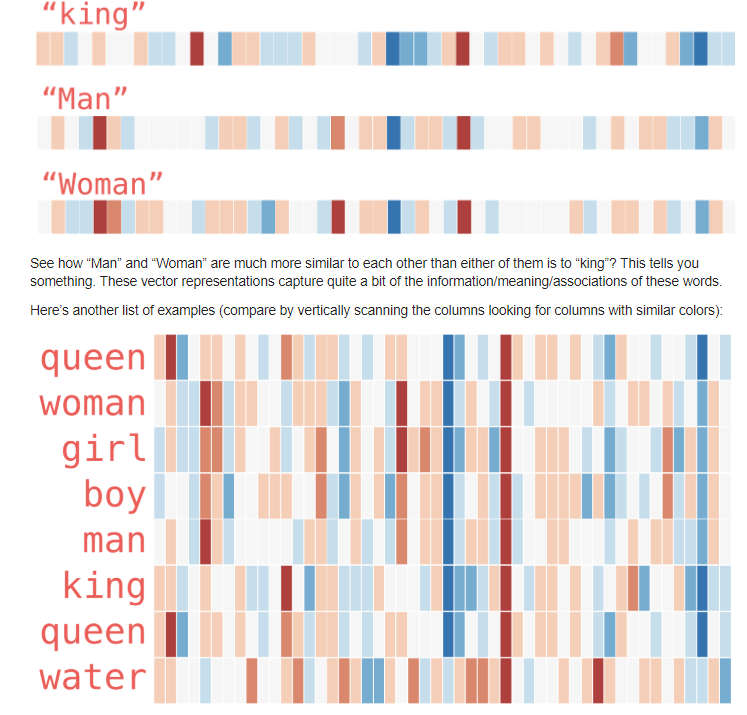
</div>

<br>
The above vectors were formed using the help of Deep learning involving Neural networks.
In order to understand how these vector were produced:
<div>
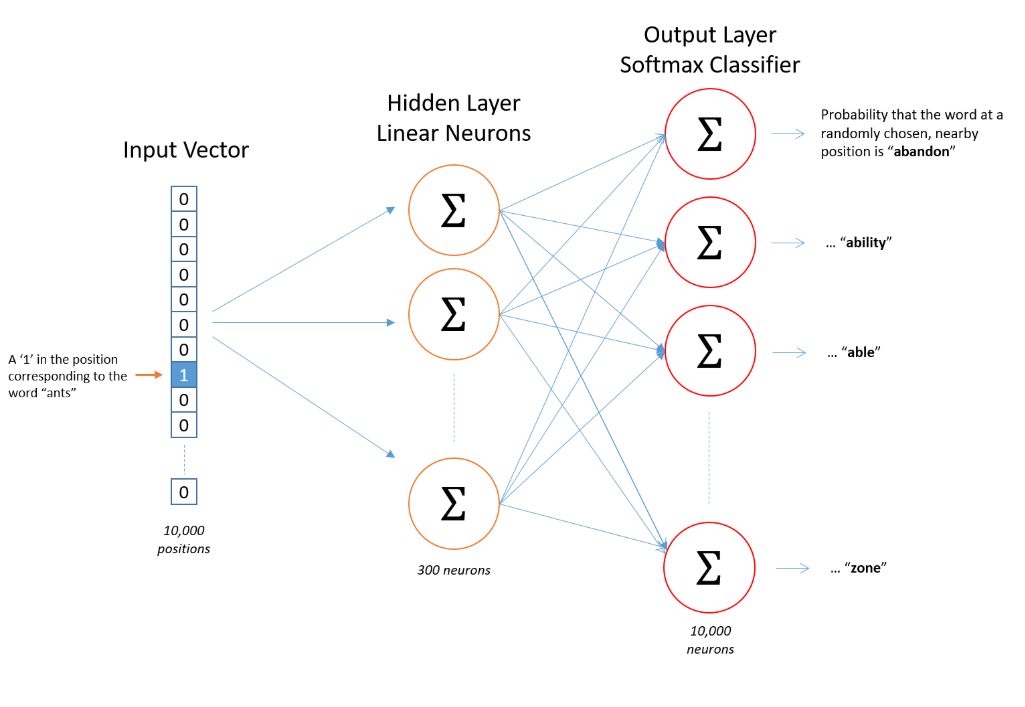
</div>
1. First of all, we cannot feed a word as string into a neural network.
Instead, we feed words as one-hot vectors, which is basically a vector of the same length as the vocabulary, filled with zeros except at the index that represents the word we want to represent, which is assigned “1”.
<br>
<br>
2. The output layer outputs probabilities for the target words from the vocabulary.
<br>
<br>
3. The rows of the hidden layer weight matrix, are actually the word vectors (word embeddings)
<br>
<br>

#### Semantic and Syntactic Relationships Intuition
So Word2Vec does it job as, suppose different words have similar context, then the Word2Vec model must give similar output and in order to have similar outputs, the vector representations must be same for those words.
<br>
<br>
Word2Vec easily gets similarity between words where the required patterns can be found using <strong>arithmetic calculations</strong> between the vectors.  
<br>
Patterns such as “Man is to Woman as Brother is to Sister” can be generated through algebraic operations on the vector representations of these words such that the vector representation of “Brother” - ”Man” + ”Woman” produces a result which is closest to the vector representation of “Sister” in the model.

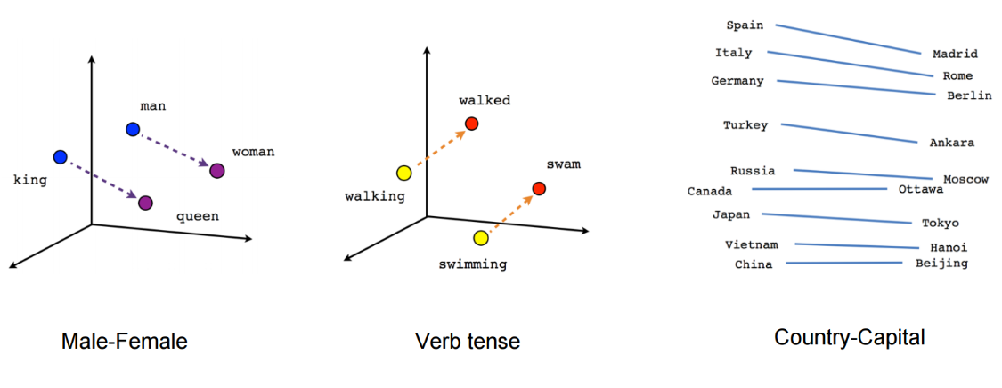

In [29]:
############################################# For Word2Vec using gensim #######################################################

from gensim.models import Word2Vec

In [30]:
# Creating the list of list format for input 
words_inp = []

for i in range(len(data['Article_Title'])):
    temp= word_tokenize(data['Article_Title'][i])
    words_inp.append(temp)
    
print(words_inp[:10])

[['india', 'south', 'sea', 'trade', 'war'], ['chief', 'khalsa', 'dewan', 'rule', 'regulation'], ['pioneer', 'indian', 'picture', 'world', 'screen'], ['review', 'indian', 'law', 'book', 'satish', 'banerji'], ['obituary', 'notice'], ['general'], ['oriental', 'hidayui', 'ool', 'islam'], ['oriental', 'amicable', 'number', 'arabian'], ['oriental', 'memoranda', 'voyage', 'ganges'], ['oriental', 'bryce', 'christian', 'instructor']]


The Word2Vec model from gensim library has some <strong>parameters</strong> which needs to be manually fed
<br>
1. min_count: Using words with minimum count
2. size: Vector Embedding size
3. iter: Number of iterations taking place for updation of vector values 
4. sg(Skip-gram): The training objective of the Skip-gram model is to find word representations that are useful for
predicting the surrounding words in a sentence or a document. More formally, given a sequence of
training words w1, w2, w3, . . . , wT , the objective of the Skip-gram model is to maximize the average
log probability where c is the size of the training context (which can be a function of the center word wt). Larger
c results in more training examples and thus can lead to a higher accuracy, at the expense of the training time.
<div>
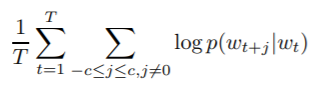
</div>

In [31]:
# Model for Word2Vec

model = Word2Vec(words_inp, min_count= 1, size= 30, workers =3, window = 5, sg=1, iter=10  )


In [32]:
# getting the embedded vector for freedom

model.wv['freedom']



array([ 0.2569365 ,  0.57835394, -0.43622062, -0.57964617, -0.25448373,
       -0.37273312,  0.60138905, -1.9731941 ,  0.5424668 ,  0.00715149,
        0.16748379,  0.08782271, -0.3907561 ,  0.4810414 ,  0.95467913,
        0.2100365 , -0.02872957,  0.93317866,  0.53381264,  0.20279102,
        0.23321304, -0.26820704,  0.5391179 , -0.7949625 , -0.3726168 ,
       -1.2892956 ,  1.1893421 ,  0.06747541, -0.59184945, -0.28238496],
      dtype=float32)

### Similarity Matrix
<hr>
As we know that words were represented as vectors, we can find similarity between them. One of the methods discussed here is <b> Cosine Similarity.</b><br>
It calculates similarity by measuring the cosine of angle between two vectors. This is calculated as:
<div>
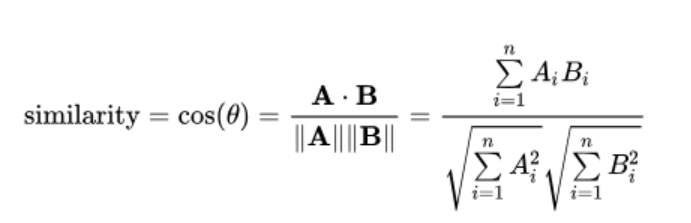
</div>
<br>
As shown below, these are the top ten words with <b>highest cosine similarity</b>

In [33]:
# getting cosine similarity between words 

model.similarity('freedom', 'independence')


C:\Users\MOTIAR REHAMAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


0.8194785

In [34]:
# getting top 10 similar words to the given word 
model.wv.most_similar('freedom')[:10]

[('objective', 0.8703410029411316),
 ('worst', 0.8616657853126526),
 ('aspiration', 0.849332869052887),
 ('courage', 0.8459879755973816),
 ('filipino', 0.8455198407173157),
 ('sign', 0.8439026474952698),
 ('liberty', 0.8433980941772461),
 ('remain', 0.8422576189041138),
 ('eire', 0.8414258360862732),
 ('bring', 0.8405450582504272)]

In [35]:
# Getting the unique trending words from the lemmatized file 

orig_url='https://drive.google.com/file/d/1-UTp3eoEm-ZJnBQPGDila3qBXwPHXws9/view'

file_id = orig_url.split('/')[-2]
dwn_url ='https://drive.google.com/uc?export=download&id=' + file_id
url     = requests.get(dwn_url).text
csv_raw = StringIO(url)
trend   = pd.read_csv(csv_raw)

trend.drop('Unnamed: 0',inplace=True, axis=1)
trending_words = trend['Trending_words']
trending_words = list(trending_words)
trending_words = list(set(trending_words))
print(len(trending_words))


635


In [36]:
# Creating the final n*n similarity matrix

n = len(trending_words)
df = pd.DataFrame(np.zeros((n,n)), columns = trending_words, index = trending_words)
for word_1 in trending_words:
    for word_2 in trending_words:
        df[word_1][word_2] = model.similarity(word_1, word_2)

C:\Users\MOTIAR REHAMAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


In [37]:
#Printing the data Frame
df

,native,student,lake,supplement,mission,philosophy,brahmin,abstract,durbar,king,...,narada,shri,aspect,harvest,letter,commercial,general,agriculture,early,day
native,1.000000,0.526087,0.293238,0.334329,0.480342,0.348359,0.486575,0.418829,0.513846,0.373187,...,0.202857,0.223106,0.491081,0.484914,0.352375,0.547868,0.481887,0.567110,0.515469,0.364800
student,0.526087,1.000000,0.189005,0.380599,0.592928,0.530623,0.584320,0.404918,0.399217,0.207255,...,0.405751,0.481670,0.453451,0.534610,0.455790,0.493711,0.453977,0.575614,0.321191,0.477648
lake,0.293238,0.189005,1.000000,0.338352,0.210045,0.186856,0.164370,0.527961,0.383159,0.327534,...,0.427224,0.070057,0.184117,0.656411,0.241010,0.263418,0.237697,0.451369,0.373704,0.286556
supplement,0.334329,0.380599,0.338352,1.000000,0.279303,0.413324,0.427116,0.537542,0.424551,0.463617,...,0.448582,0.241104,0.551450,0.298921,0.505080,0.435789,0.482132,0.425151,0.379995,0.565789
mission,0.480342,0.592928,0.210045,0.279303,1.000000,0.383922,0.475130,0.576384,0.459483,0.224262,...,0.366119,0.374360,0.454371,0.511026,0.421816,0.399262,0.410040,0.474515,0.476665,0.488299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
commercial,0.547868,0.493711,0.263418,0.435789,0.399262,0.352065,0.381685,0.497677,0.451547,0.365684,...,0.319488,0.222402,0.536189,0.506945,0.274750,1.000000,0.589627,0.727988,0.422427,0.312470
general,0.481887,0.453977,0.237697,0.482132,0.410040,0.384650,0.214861,0.509096,0.226161,0.443146,...,0.351887,0.228630,0.447340,0.454366,0.419709,0.589627,1.000000,0.333253,0.569625,0.248967
agriculture,0.567110,0.575614,0.451369,0.425151,0.474515,0.505263,0.455012,0.573721,0.423856,0.195016,...,0.350959,0.222136,0.687894,0.585698,0.399825,0.727988,0.333253,1.000000,0.411249,0.431950
early,0.515469,0.321191,0.373704,0.379995,0.476665,0.483933,0.497210,0.582821,0.325667,0.456810,...,0.394128,0.026169,0.696919,0.670825,0.387459,0.422427,0.569625,0.411249,1.000000,0.449872


In [5]:
#Saving into CSV File
df.to_csv('Similarity_matrix_of_trending_words.csv')

NameError: name 'df' is not defined

### Forming bigrams and Trigrams<hr>
There are lot of individual words which do not have meaning until clubbed together to form phrases. There are words which come frequently together, and infrequently in other contexts. Example: Indian Civil Service should be treated as a single word.
<br><br>
But we don't need phrases like "this is", "and after" etc.
<br><br>
In order to make resonable and relevant phrases, we use this formula:
<div>
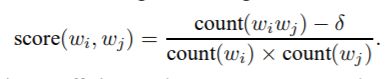
</div>
The δ is used as a <b>discounting coefficient</b> and prevents too many phrases consisting of very infrequent words to be formed. The bigrams with score above the chosen threshold are then used as
phrases

In [38]:
# Creating list of list for the final_corpus

final_corpus = []

for i in range(len(data['Article_Title'])):
  words = word_tokenize(data['Article_Title'][i])
  final_corpus.append(words) 

In [39]:
# Creating Bigrams and Trigrams

from gensim.models.phrases import Phraser, Phrases

common_terms = ["of", "with", "without", "and", "or", "the", "a"]

phrases = Phrases(final_corpus, common_terms=common_terms)
bigram = Phraser(phrases)

phrases = Phrases(list(bigram[final_corpus]), common_terms=common_terms)
trigram = Phraser(phrases)

all_sentences = list(trigram[list(bigram[final_corpus])])

In [40]:
for i in range(len(all_sentences)):
  all_sentences[i] = ' '.join([word for word in all_sentences[i]])

data['Ngrams'] = all_sentences

In [41]:
data.head()

,Article_Title,Year,Location,Ngrams
0,india south sea trade war,0.0,Tokyo,india south_sea_trade war
1,chief khalsa dewan rule regulation,195.0,Kolkata,chief khalsa dewan rule_regulation
2,pioneer indian picture world screen,941.0,Mumbai,pioneer indian picture world screen
3,review indian law book satish banerji,1096.0,Allahabad,review indian law book satish banerji
4,obituary notice,1180.0,London,obituary_notice
